In [1]:
from spatial_statistics_tools import *
from process_images import *
from utilities import *
from pylab import figure, cm
from matplotlib.colors import LogNorm
#from skimage import feature, restoration, segmentation, exposure, img_as_float
#from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
#from skimage.filters import gaussian
#from datetime import datetime

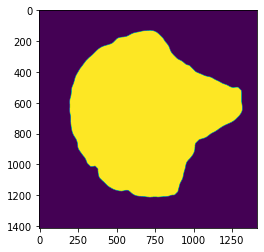

In [2]:
mask = np.load("masks/mask2_clca.npy")
plt.imshow(mask)
plt.show()

In [3]:
def truncated_gaussian(mean, sigma, N=1):
    """
    ...
    """
    return np.round(np.random.normal(mean, sigma, N))


def generate_random_cell_image(mask, pixel_size=1, pixel_int=10, n_pixels=1000, n_pixels_cluster=0, cluster_size=100, cluster_pos=(0,0), desired_int=2000000000, binary=False):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)
    
    if n_pixels_cluster > n_pixels:
        print("Error! Total number of pixels n_pixels must be larger than or equal to n_pixels_cluster!")
        return

    n_pixels_uniform = n_pixels - n_pixels_cluster

    # define size of cluster := FWHM = 2.355 * sigma (for Gaussian)
    sigma = cluster_size/2.355
    mean_x, mean_y = cluster_pos

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_pixels_uniform:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
            arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]
            count+=1

    # generate additional pixels around a defined cluster 
    count=0
    while count<n_pixels_cluster:
        rnd_x = int(truncated_gaussian(mean_x+x_lim/2, sigma))
        rnd_y = int(truncated_gaussian(mean_y+y_lim/2, sigma))
        if (rnd_x < x_lim) and (rnd_y < y_lim):
            if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
                arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]    
                count+=1

    if np.sum(arr) != pixel_int*n_pixels:
        print("Error! Amount of points in resulting image is not equal to specified number of points!")
        return

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=pixel_size)
    arr = gaussian(arr, sigma=3)
    
    # if binary, then image will only have values 1 or 0
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97

    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    return img_real, img_csr


def get_K_diff(mask, img_real, img_csr, range_of_t, width, printout=True):
    """
    ...
    """
    K_values_real, K_values_ring_real, corr_real = ripleys_K_fast_ring(img_real, mask, range_of_t, width, printout)
    K_values_csr, K_values_ring_csr, corr_csr = ripleys_K_fast_ring(img_csr, mask, range_of_t, width, printout)
    K_diff = np.array(K_values_real) - np.array(K_values_csr)
    K_ring_diff = np.array(K_values_ring_real) - np.array(K_values_ring_csr)
    return K_diff, K_ring_diff, corr_real, corr_csr

In [13]:
width = 1
pixel_size=1
pixel_int=1
n_pixels=1500
n_pixels_cluster=500
cluster_size=200
cluster_pos=(0,0)
desired_int=1000000
binary=False

range_of_t = list(range(20)) + list(np.linspace(20, 1000, 60))
#range_of_t = np.linspace(1, 1200, 40)

folder = "toy_data_results"

for i in range(0,5):
    
   # cluster_pos=(-200+20*i,+200-20*i)
    n_total = 2000 - 400*i
    n_pixels = int(n_total * 0.7)
    n_pixels_cluster = int(n_total * 0.3)
    
    #width = 1+i
    
    filename = f"ring_K_cluster_#{i+1}.pdf"
    path = os.path.join(folder, filename)
    print(f"Creating {filename}...")
      
    img_real, img_csr = generate_random_cell_image(mask, pixel_size, pixel_int, n_pixels, n_pixels_cluster, cluster_size, cluster_pos, desired_int, binary)

    K_diff, K_ring_diff, corr_real, corr_csr = get_K_diff(mask, img_real, img_csr, range_of_t, width, True)

    title = f"pixel size={pixel_size}, pixel int={pixel_int}, no. pixels={n_pixels}, no. pixels in cluster={n_pixels_cluster}, cluster size={cluster_size}, pixel sum per image={desired_int}"
    # works only if number odd, should be given for autocorrelation
    len_ = corr_real.shape[0]
    lim_lower = -int(len_/2)
    lim_upper = int(len_/2)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0][0].imshow(img_real)
    im1 = ax[0][0].imshow(img_real)
    ax[0][0].set_title("Original (\"real\") image")
    ax[0][1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
    im2 = ax[0][1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper], origin='lower')    
    ax[1][0].set_title("Autocorr. real image")

    ax[1][0].set_title("K function for (real)-(CSR)")
    ax[1][0].plot(range_of_t, K_diff)
    ax[1][0].set_xlabel("$t$")
    ax[1][0].set_ylabel("$K(t)$")

    ax[1][1].set_title(f"Ring K function for (real)-(CSR), width={width}")
    ax[1][1].plot(range_of_t, K_ring_diff)
    ax[1][1].set_xlabel("$t$")
    ax[1][1].set_ylabel("$K_{Ring}(t)$")

    plt.colorbar(im1, ax=ax[0, 0])
    plt.colorbar(im2, ax=ax[0, 1])

    fig.suptitle(title)
    plt.savefig(path)
   # plt.show()
    plt.close()
    
print("Completed!")

Creating ring_K_cluster_#1.pdf...
Completed in 12.81 seconds
Completed in 10.68 seconds
Creating ring_K_cluster_#2.pdf...
Completed in 11.63 seconds
Completed in 12.84 seconds
Creating ring_K_cluster_#3.pdf...
Completed in 11.19 seconds
Completed in 10.78 seconds
Creating ring_K_cluster_#4.pdf...
Completed in 15.55 seconds
Completed in 10.88 seconds
Creating ring_K_cluster_#5.pdf...
Completed in 11.18 seconds
Completed in 11.02 seconds
Completed!


In [8]:
np.sum(K_diff)

4738685.203801382

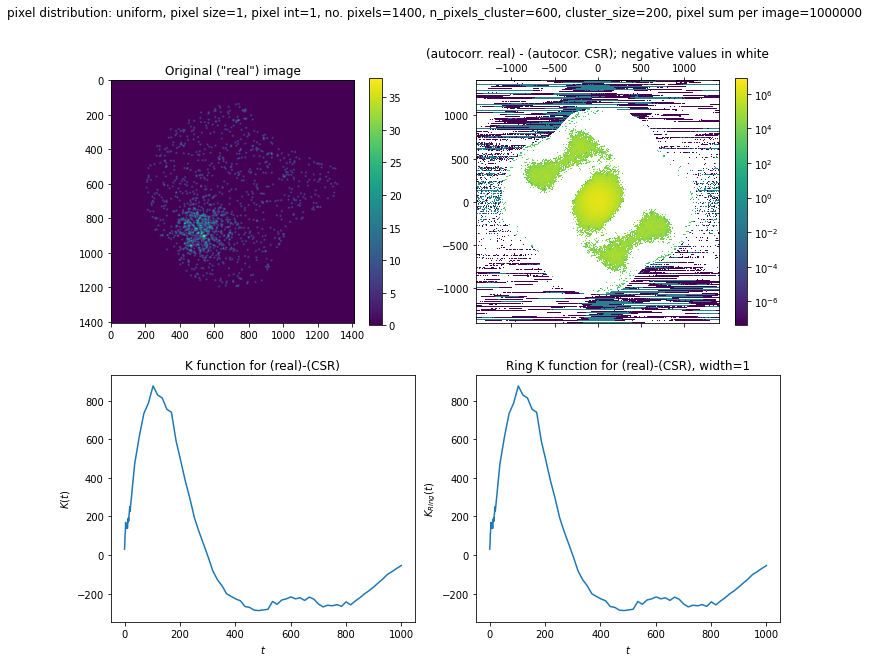

In [88]:

# works only if number odd, should be given for autocorrelation
len_ = corr_real.shape[0]
lim_lower = -int(len_/2)
lim_upper = int(len_/2)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0][0].imshow(img_real)
im1 = ax[0][0].imshow(img_real)
ax[0][0].set_title("Original (\"real\") image")
ax[0][1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
im2 = ax[0][1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper], origin='lower')    
ax[1][0].set_title("Autocorr. real image")

ax[1][0].set_title("K function for (real)-(CSR)")
ax[1][0].plot(range_of_t, K_diff)
ax[1][0].set_xlabel("$t$")
ax[1][0].set_ylabel("$K(t)$")

ax[1][1].set_title(f"Ring K function for (real)-(CSR), width={width}")
ax[1][1].plot(range_of_t, K_diff)
ax[1][1].set_xlabel("$t$")
ax[1][1].set_ylabel("$K_{Ring}(t)$")

plt.colorbar(im1, ax=ax[0, 0])
plt.colorbar(im2, ax=ax[0, 1])

fig.suptitle(title)
plt.show()

In [355]:
wrong = ax[1][0].get_yticks()

ax[1][0].set_yticks([0, 3, 0, 500, 1000, 2000, 2500, 3000])

print(ax[1][0].get_yticks())

[   0    3    0  500 1000 2000 2500 3000]


In [327]:
np.min(corr_real-corr_csr)

-329566.75

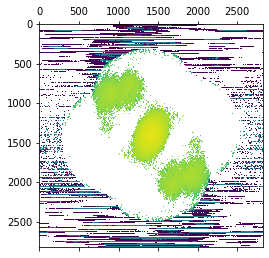

In [312]:
from pylab import figure, cm
from matplotlib.colors import LogNorm
#plt.imshow(corr_real-corr_csr)


plt.matshow(corr_real-corr_csr, norm=LogNorm())
#plt.yticks(auto_corr_ticks)
plt.show()

In [299]:
auto_corr_ticks_wrong = list(range(0, y))
auto_corr_ticks = list(range(-int(y/2),0))+[0]+list(range(0,int(y/2)))

In [300]:
len(auto_corr_ticks_wrong)

2823

In [280]:
vmin = np.min(corr_real)
vmax = np.max(corr_real)
print(vmin, vmax)

vmin = np.min(corr_csr)
vmax = np.max(corr_csr)
print(vmin, vmax)

-0.6320988 8803131.0
-0.22123456 1274734.6


In [261]:
for i in range(9):
    
    n_total = 4000 - 400*i
    n_pixels = int(n_total * 0.7)
    n_pixels_cluster = int(n_total * 0.3)
    
    print(n_pixels_cluster/n_pixels)

0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42879019908116384
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855


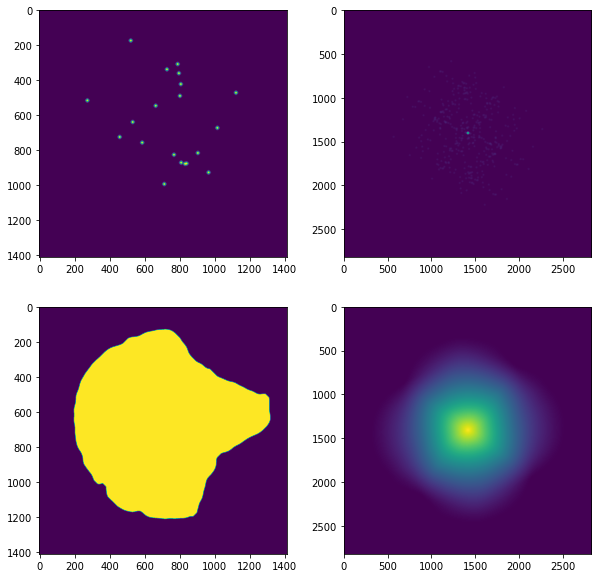

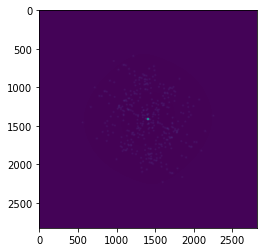

In [24]:
pixel_size=1
pixel_int=1
n_pixels=2000
n_pixels_cluster=700
cluster_size=200
cluster_pos=(0,0)
desired_int=1000000
binary=False

arr1, mask1 = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels, desired_int, binary)

arr1 = scale_image(arr1, desired_int)
mask1 = scale_image(mask1, desired_int)

auto_corr1 = signal.correlate(arr1.astype('float32'), arr1.astype('float32'), method='fft')
auto_corr_mask1 = signal.correlate(mask1.astype('float32'), mask1.astype('float32'), method='fft')

#arr2, _ = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels, desired_int, binary)
#auto_corr2 = signal.correlate(arr2.astype('float32'), arr2.astype('float32'), method='fft')


fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(arr1)
ax[0][1].imshow(auto_corr1)
ax[1][0].imshow(mask1)
ax[1][1].imshow(auto_corr_mask1)
plt.show()

plt.imshow(auto_corr1-auto_corr_mask1)
plt.show()

For more randomness, the autocorrelation is more uniform in all directions...

Last image is what we sum over!
Observation(???): middle point is so high, that if the points are not that far apart, K_diff function keeps on rising.
Could we perhaps scale every product by the square of the average intensity? To get rid of the squared stuff or smth.

Is there a better metric to compare the autocorrelations than simply the K function plot?

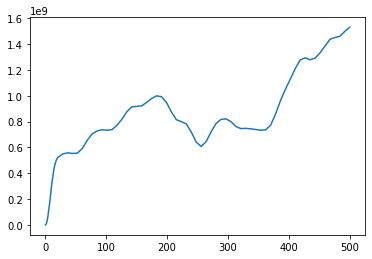

In [27]:
# array whose elements are equal to their Euclidean distance from the center
diff_xy = distance_arr(auto_corr1)

range_of_t = list(range(20)) + list(np.linspace(20, 500, 60))

K_cell = []
K_mask = []

for t in range_of_t:
    # array containing the auto-correlation up to distance t
    auto_corr_t = cut_circle(auto_corr1, radius=t, diff_xy=diff_xy)
    auto_corr_mask_t = cut_circle(auto_corr_mask1, radius=t, diff_xy=diff_xy)
    
    K_cell.append(np.sum(auto_corr_t))
    K_mask.append(np.sum(auto_corr_mask_t))
    
#plt.plot(range_of_t, K_cell)
#plt.plot(range_of_t, K_mask)
plt.plot(range_of_t, np.array(K_cell)-np.array(K_mask))
plt.show()

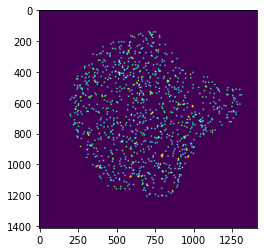

In [53]:
pixel_size=1 
pixel_int=10 
n_pixels=1000

img_real, img_csr = generate_cell_image_uniform(mask, pixel_size, pixel_int, n_pixels)


plt.imshow(exposure.equalize_hist(img_real)>0.97)
plt.show()

In [66]:
np.mean(full_auto1)

1254.8099

In [47]:
exposure.equalize_hist(img_real)>0.9

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
def generate_cell_image_uniform(mask, pixel_size=1, pixel_int=10, n_pixels=1000, desired_int=2000000000, binary=False):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_pixels:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1:
            arr[rnd_x, rnd_y] = pixel_int
            count+=1

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=pixel_size)
    arr = gaussian(arr, sigma=3)
    
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97
        
    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    return img_real, img_csr

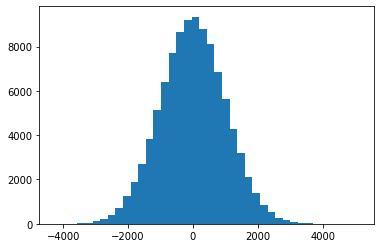

In [88]:
gauss_cont = np.random.normal(0, 1000, 100000)
gauss_trunc = np.round(gauss_cont)
plt.hist(gauss_trunc, bins=40)
plt.show()

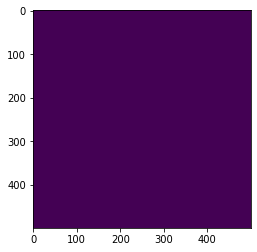

In [74]:
base = np.zeros((500,500))
plt.imshow(base)
plt.show()

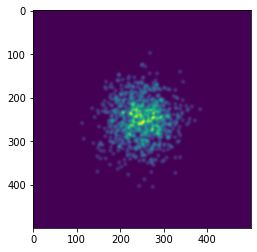

In [105]:



cluster_pos = (0,0)
n_pixels_cluster = 1000
pixel_int = 10
cluster_size = 100
pixel_size = 1


arr = np.zeros((500,500))

x_dim, y_dim = arr.shape

mean_x, mean_y = cluster_pos

# size of cluster := FWHM = 2.355 * sigma (for Gaussian)
sigma = cluster_size/2.355


for i in range(n_pixels_cluster):
    
    rnd_x = int(truncated_gaussian(mean_x+x_dim/2, sigma))
    rnd_y = int(truncated_gaussian(mean_y+y_dim/2, sigma))
    
    if rnd_x < x_dim and rnd_y < y_dim:
    #print(rnd_x)
        arr[rnd_x, rnd_y] = pixel_int

    
# slightly dilate and blur the pixels to enlarge them
arr = binary_dilation(arr, iterations=pixel_size)
arr = gaussian(arr, sigma=3)

plt.imshow(arr)
plt.show()

------

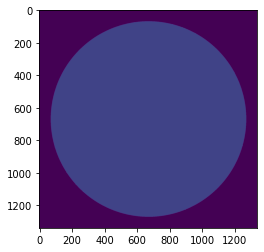

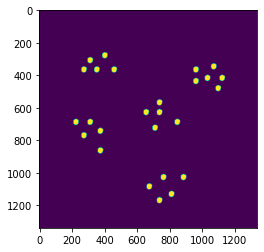

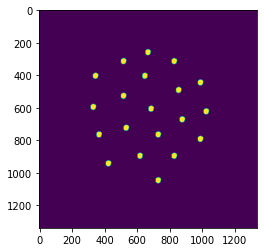

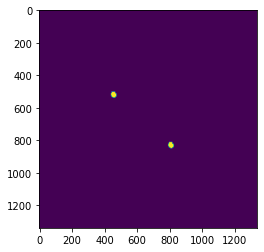

In [65]:
import cv2 
mask_csr = cv2.imread("csr.png")
mask_csr = cv2.cvtColor(mask_csr, cv2.COLOR_BGR2GRAY)
mask_csr[mask_csr<50] = 10
mask_csr[mask_csr>50] = 0
mask_csr = scale_image(mask_csr, 1000)

two_dots = cv2.imread("two_dots.png")
two_dots = cv2.cvtColor(two_dots, cv2.COLOR_BGR2GRAY)
two_dots[two_dots<50] = 10
two_dots[two_dots>50] = 0
two_dots = scale_image(two_dots, 1000)

disp = cv2.imread("disperse.png")
disp = cv2.cvtColor(disp, cv2.COLOR_BGR2GRAY)
disp[disp<=230] = 10
disp[disp>230] = 0
disp = scale_image(disp, 1000)

cluster = cv2.imread("cluster.png")
cluster = cv2.cvtColor(cluster, cv2.COLOR_BGR2GRAY)
cluster[cluster<=230] = 10
cluster[cluster>230] = 0
cluster = scale_image(cluster, 1000)



plt.imshow(mask_csr)
plt.show()
plt.imshow(cluster)
plt.show()
plt.imshow(disp)
plt.show()
plt.imshow(two_dots)
plt.show()

In [60]:
np.sum(disp), np.sum(mask_csr), np.sum(cluster)

(1000.0000000000001, 1000.0000000000003, 1000.0000000000003)

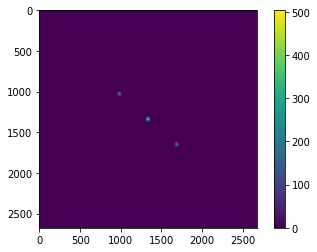

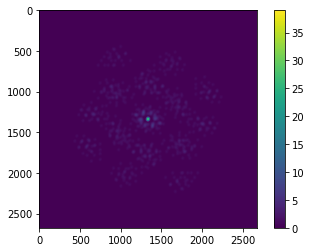

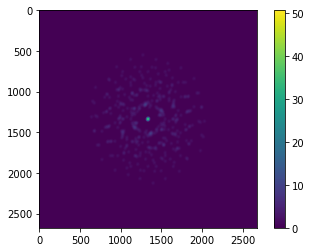

In [67]:
corr_disp = signal.correlate(disp, disp, method='fft') 
corr_cluster = signal.correlate(cluster, cluster, method='fft')
corr_csr = signal.correlate(mask_csr, mask_csr, method='fft')
corr_two_dots = signal.correlate(two_dots, two_dots, method='fft')


plt.imshow(corr_two_dots)
plt.colorbar()
plt.show()
plt.imshow(corr_cluster)#-corr_csr)
plt.colorbar()
plt.show()
plt.imshow(corr_disp)#-corr_csr)
plt.colorbar()
plt.show()

In [112]:
b = np.load("K_data_averaged.npy")
print(np.min(b[1]))

-13626.246554964979


In [52]:
a = b[1]
ts = a[0,:]
Ks = a[1,:]
np.min(Ks)

NameError: name 'b' is not defined

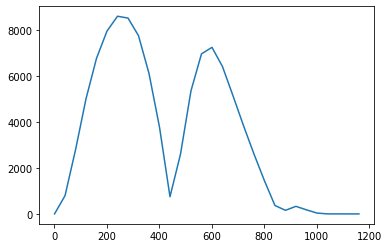

In [53]:

plt.plot(ts, Ks)

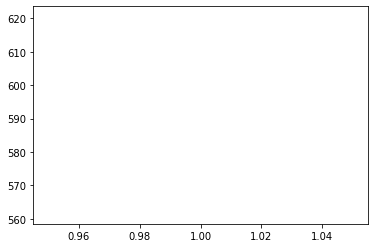

In [117]:
range_of_t = a[0][0]
clc_type = a[0][3]
K_diffs = [d[2] for d in a]

K_diffs_mean = np.mean(K_diffs, axis=0)
K_diffs_std = np.std(K_diffs, axis=0) 

plt.plot(range_of_t, K_diffs_mean, label=clc_type)

In [4]:
path="test"
file = np.array([1,2,3,4])

store_file(file, path)

In [44]:
K_data_averaged = load_file("K_data_averaged")
print(K_data_averaged[0][1])
print("\n")
print(K_data_averaged[1][1])

[1.31148406e+01 2.08260065e+03 6.71782350e+03 1.27853830e+04
 1.89492280e+04 2.49062955e+04 3.04261614e+04 3.60528384e+04
 4.14405691e+04 4.60198844e+04 4.94274951e+04 5.11387257e+04
 5.07724168e+04 4.80153222e+04 4.26320070e+04 3.54668810e+04
 2.76217096e+04 2.02766310e+04 1.39102601e+04 8.92325948e+03
 5.47053274e+03 3.33686477e+03 2.10365850e+03 1.26969259e+03
 6.81313689e+02 2.95779883e+02 4.91937870e+01 1.56076475e+00
 9.82989190e-02 9.51938356e-02]


[ 9.08301926e+00  6.41181638e+02  1.30072036e+03  1.56032033e+03
  1.48786135e+03  9.36635703e+02 -1.20909154e+02 -1.64269057e+03
 -3.20721643e+03 -4.31222332e+03 -4.88859735e+03 -5.04536469e+03
 -5.12035508e+03 -5.61104644e+03 -6.73076207e+03 -8.37222516e+03
 -9.97481349e+03 -1.14964020e+04 -1.29268434e+04 -1.36262466e+04
 -1.33442537e+04 -1.20719866e+04 -1.00377416e+04 -7.60059484e+03
 -5.16427209e+03 -2.88132317e+03 -1.14689215e+03 -2.31178375e+02
  6.29625887e+00  3.17165088e+00]


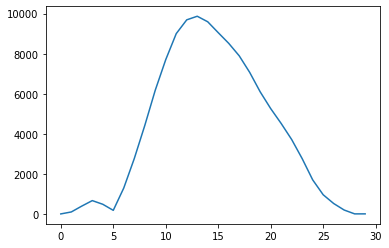

In [49]:
plt.plot(K_data_averaged[1][2])

In [18]:
ts

1

In [35]:
a[2]

array([1.10754313e+00, 7.94033829e+02, 2.78429771e+03, 5.00297257e+03,
       6.75907500e+03, 7.94163053e+03, 8.58286174e+03, 8.50332216e+03,
       7.73931012e+03, 6.09697830e+03, 3.76823943e+03, 7.45846918e+02,
       2.59205564e+03, 5.34671944e+03, 6.94871925e+03, 7.23214071e+03,
       6.39915882e+03, 5.13380805e+03, 3.83806555e+03, 2.60186824e+03,
       1.44020649e+03, 3.66178791e+02, 1.56394534e+02, 3.29614190e+02,
       1.77401975e+02, 3.77513112e+01, 1.31221980e+00, 1.25465056e+00,
       2.01232638e-01, 1.99913565e-01])

In [51]:
len(range(10,100))

90